In [514]:
!pip install pycountry-convert
!pip install pycountry

In [292]:
# Datos
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import nltk as nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
import pycountry


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# `cleaned_reviews.csv`

## Análisis Exploratorio

### Carga de datos

In [220]:
df_cleaned_reviews = pd.read_csv('dataset/cleaned_reviews.csv')

In [221]:
#German
#from google.colab import drive
#drive.mount('/content/drive')

#df_cleaned_reviews = pd.read_csv('/content/drive/MyDrive/Orga de datos/Orga de datos TP1 1C2024/cleaned-reviews.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Revisión de datos

Comprueba la estructura de los datos, como la cantidad de filas y columnas, los tipos de datos de cada columna, y si hay datos faltantes o valores atípicos.

In [222]:
df_cleaned_reviews.head()

,Unnamed: 0,reviews,rates,date,country,verified,comments
0,0,✅ Trip Verified | Excellent service both on th...,5,2023-01-24,United Kingdom,True,excellent service ground board first class pro...
1,1,✅ Trip Verified | Good lounge at Cape Town. O...,9,2023-01-24,United Kingdom,True,good lounge cape town time departure drink hig...
2,2,✅ Trip Verified | A really excellent journey....,9,2023-01-23,United Kingdom,True,really excellent journey lounge overcrowded la...
3,3,✅ Trip Verified | This flight was one of the ...,9,2023-01-21,United Kingdom,True,flight one worst ever life wanted pamper bough...
4,4,Not Verified | It seems that there is a race t...,2,2023-01-19,United States,False,verified seems race bottom amongst airline can...


In [223]:
# Cantidad de filas y columnas
print(df_cleaned_reviews.shape)

(3411, 7)


In [224]:
df_cleaned_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3411 entries, 0 to 3410
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3411 non-null   int64 
 1   reviews     3411 non-null   object
 2   rates       3411 non-null   int64 
 3   date        3411 non-null   object
 4   country     3411 non-null   object
 5   verified    3411 non-null   bool  
 6   comments    3411 non-null   object
dtypes: bool(1), int64(2), object(4)
memory usage: 163.3+ KB


valores nulos

In [225]:
df_cleaned_reviews.isnull().sum()

Unnamed: 0    0
reviews       0
rates         0
date          0
country       0
verified      0
comments      0
dtype: int64

Evaluamos que features son categoricas

In [226]:
df_cleaned_reviews["country"].value_counts()

country
United Kingdom           2165
United States             361
Australia                 147
Canada                    104
Germany                    60
                         ... 
Iceland                     1
Saint Kitts and Nevis       1
Costa Rica                  1
Cayman Islands              1
Oman                        1
Name: count, Length: 69, dtype: int64

In [227]:
df_cleaned_reviews["verified"].value_counts()

verified
False    2435
True      976
Name: count, dtype: int64

In [228]:
df_cleaned_reviews["verified"].value_counts()

verified
False    2435
True      976
Name: count, dtype: int64

### Limpieza de datos

Limpia los datos tratando con valores faltantes, valores atípicos, duplicados, y cualquier otro problema que pueda afectar la calidad de los datos y los análisis posteriores.

In [229]:
# Eliminamos la columna "Unnamed: 0"
df_cleaned_reviews = df_cleaned_reviews.drop(columns=['Unnamed: 0'])

# Convertir la columna "date" a tipo datetime
df_cleaned_reviews['date'] = pd.to_datetime(df_cleaned_reviews['date'])

# Eliminar filas duplicados.
df_cleaned_reviews.drop_duplicates(inplace=True)

# La columna "country" es una variable categórica, por lo que la convertimos a tipo "category"
df_cleaned_reviews['country'] = df_cleaned_reviews['country'].astype('category')

### Resumen estadístico

Calcula estadísticas descriptivas como la media, la mediana, la desviación estándar, los percentiles, etc., para comprender mejor la distribución y la variabilidad de los datos.

In [230]:
df_cleaned_reviews.describe()

,rates,date
count,3410.000000,3410
mean,4.819941,2017-05-18 07:24:14.780058624
min,1.000000,2014-05-18 00:00:00
25%,2.000000,2015-08-15 00:00:00
50%,4.000000,2016-12-08 12:00:00
75%,8.000000,2018-09-15 18:00:00
max,10.000000,2023-01-24 00:00:00
std,3.145510,NaN


### Agregamos informacion

In [231]:
# separamo en año, mes y día
df_cleaned_reviews['year'] = df_cleaned_reviews['date'].dt.year
df_cleaned_reviews['month'] = df_cleaned_reviews['date'].dt.month
df_cleaned_reviews['day'] = df_cleaned_reviews['date'].dt.day

df_cleaned_reviews['day_of_week'] = df_cleaned_reviews['date'].dt.dayofweek + 1

## Graficos

### Cantidad de comentarios por país

Nota: cant_coment_pais para selecionar una columna hacer
- cant_coment_pais[False] -> sin comillas dado que es un booleano
- cant_coment_pais.iloc[:, 0]

In [232]:
cant_coment_pais = df_cleaned_reviews.groupby(["rates", "verified"])["reviews"].count().unstack()

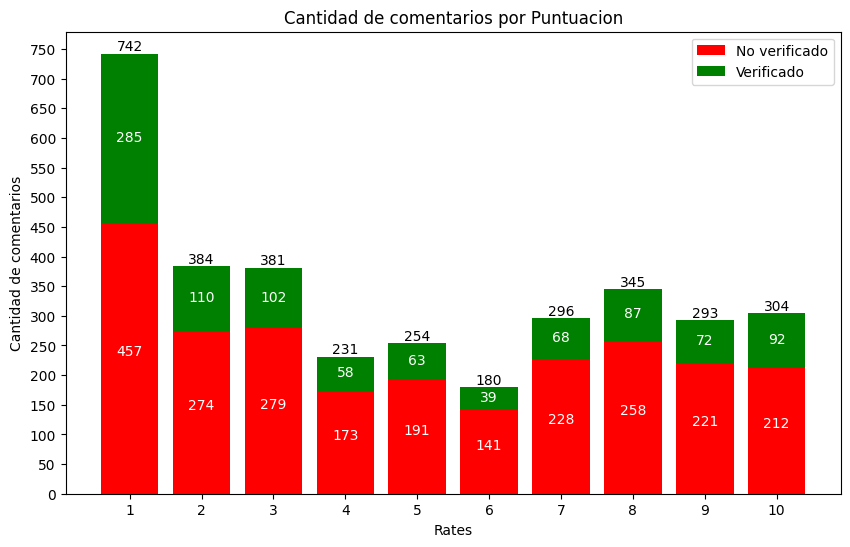

In [233]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(cant_coment_pais.index, cant_coment_pais[False], label='No verificado', color='red')
ax.bar(cant_coment_pais.index, cant_coment_pais[True], bottom=cant_coment_pais[False], label='Verificado', color='green')

for i, rate in enumerate(cant_coment_pais.index):
    total = cant_coment_pais.loc[rate].sum()
    ax.text(rate, total, f'{total}', ha='center', va='bottom')
    #print(i, rate, total)

    total_false = cant_coment_pais.loc[rate][False]
    ax.text(rate, total_false/2, f'{total_false}', ha='center', va='bottom', color='white')

    total_true = cant_coment_pais.loc[rate][True]
    ax.text(rate, total_false + total_true/2-10, f'{total_true}', ha='center', va='bottom', color='white')

ax.set_xticks(cant_coment_pais.index)
ax.set_yticks(range(0, 751, 50))

ax.set_xlabel('Rates')
ax.set_ylabel('Cantidad de comentarios')
ax.set_title('Cantidad de comentarios por Puntuacion')
ax.legend()

plt.show()

### Distribución de las calificaciones a lo largo del tiempo

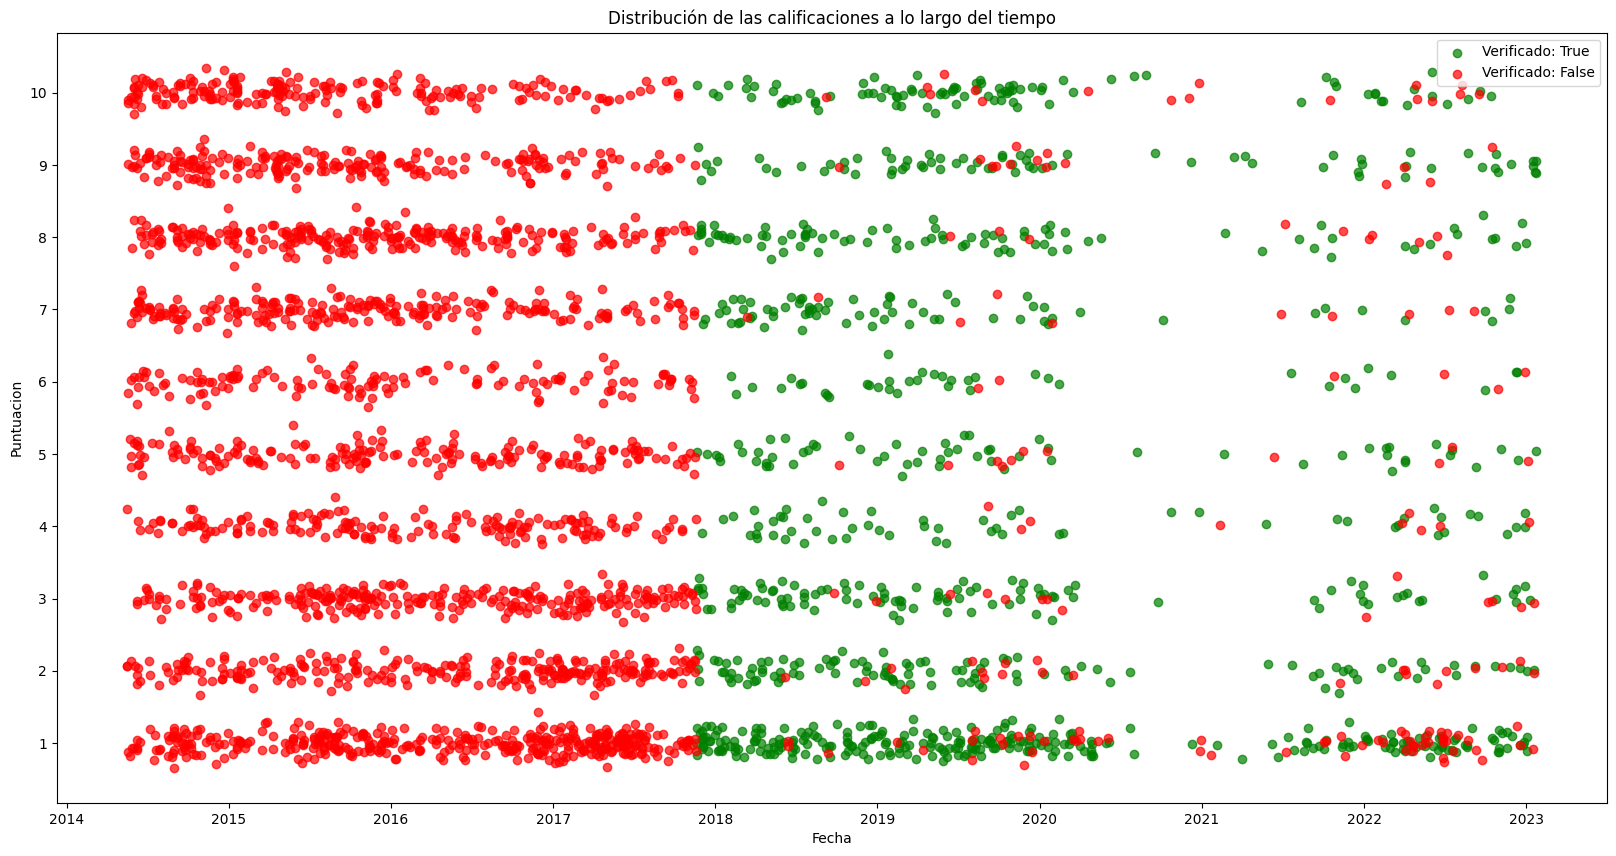

In [234]:
fig, ax = plt.subplots(figsize=(20, 10))

# Añadimos un poco de "ruido" a los datos de 'rates' para evitar la superposición de puntos
y_jittered = df_cleaned_reviews['rates'] + np.random.normal(0, 0.12, df_cleaned_reviews.shape[0])

# Creamos un diccionario de colores para la variable 'verified'
colors = {True: 'green', False: 'red'}  # Cambia los colores según tus preferencias

# Creamos el gráfico de dispersión con Matplotlib
for label, color in colors.items():
    ax.scatter(df_cleaned_reviews[df_cleaned_reviews['verified'] == label]['date'],
               y_jittered[df_cleaned_reviews['verified'] == label],
               c=color, label=f'Verificado: {label}', alpha=0.7)

ax.set_title('Distribución de las calificaciones a lo largo del tiempo')
ax.set_xlabel('Fecha')
ax.set_ylabel('Puntuacion')

ax.set_yticks(range(1, 11))

ax.legend(loc='upper right')

plt.show()

Del grafico anterior se puede observar que entre 2014 a 2018 las reviews no se verificaban y ademas se realizaban mas cantidad de veces.

Que performance tiene el promedio de calificaciones por mes

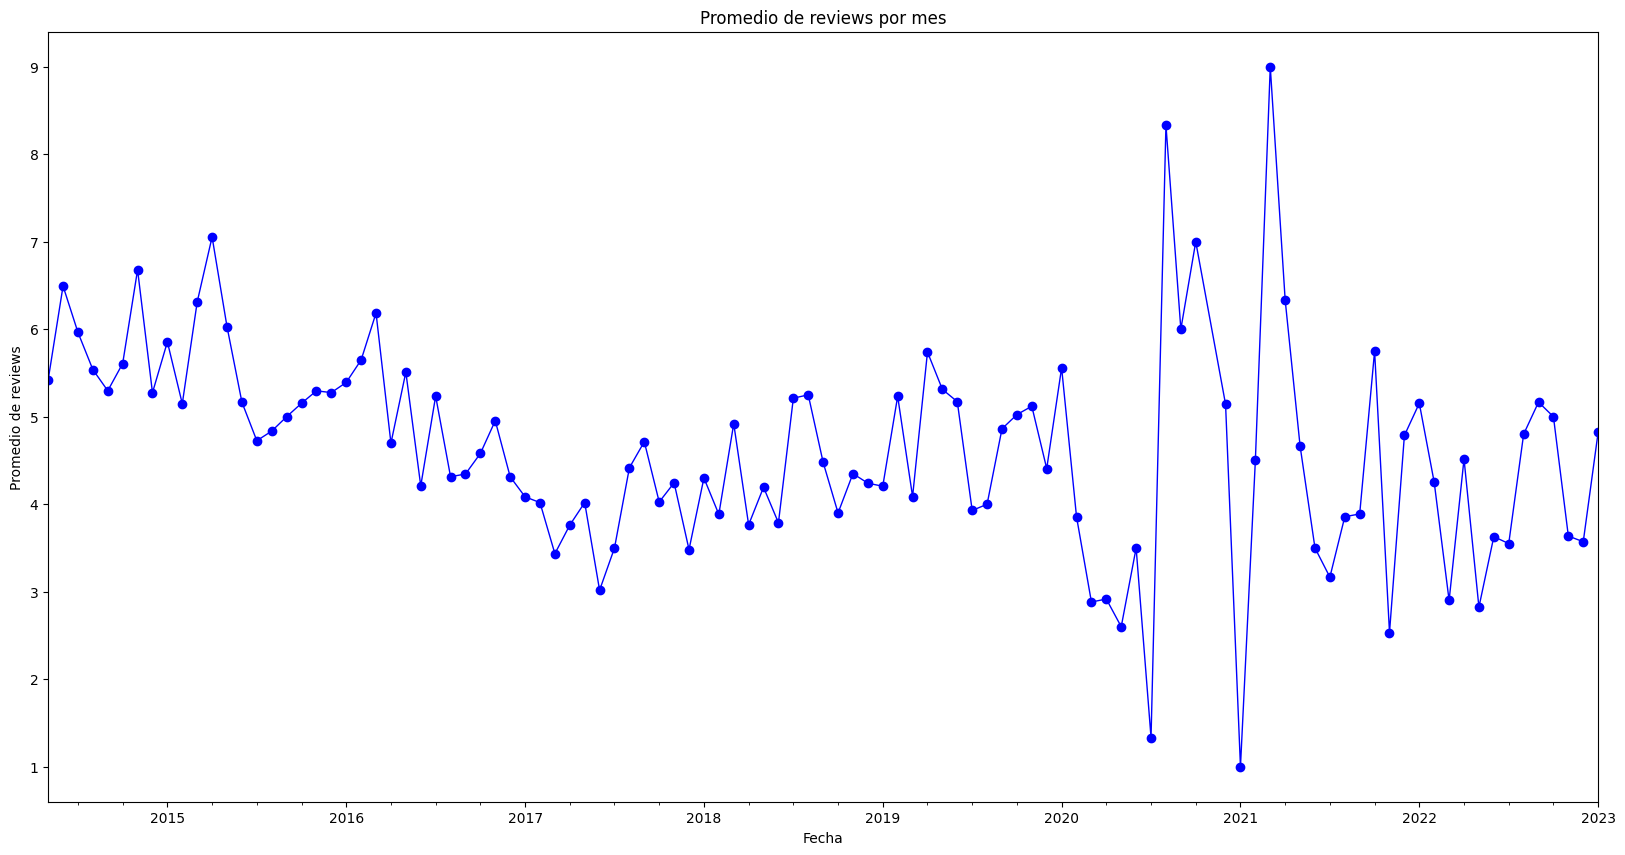

In [235]:
# las review mejoraron a lo largo del tiempo
fig, ax = plt.subplots(figsize=(20, 10))

# usamos el promedio de rates por mes
df_cleaned_reviews['month'] = df_cleaned_reviews['date'].dt.to_period('M')
average_rates_per_month = df_cleaned_reviews.groupby('month')['rates'].mean()

average_rates_per_month.plot(ax=ax, color='blue', marker='o', linestyle='-', linewidth=1, markersize=6)

ax.set_xlabel('Fecha')
ax.set_ylabel('Promedio de reviews')
ax.set_title('Promedio de reviews por mes')

plt.show()

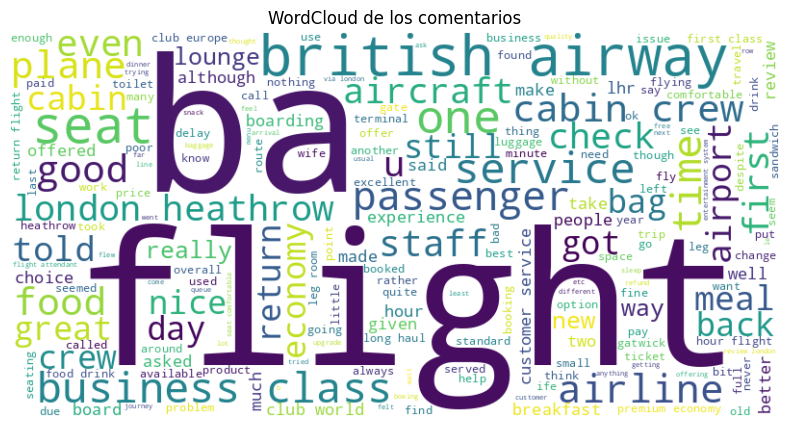

In [236]:
comments = df_cleaned_reviews['comments'].tolist()

all_words = []
for comment in comments:
    if isinstance(comment, str):
        tokens = word_tokenize(comment.lower())
        all_words.extend(tokens)

stop_words = set(stopwords.words('english'))


filtered_words = [word for word in all_words if word not in stop_words]

text = ' '.join(filtered_words)

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('WordCloud de los comentarios')
plt.axis("off")
plt.show()

# `filtered_customer_booking.csv`

## Análisis Exploratorio

### Carga de datos

In [237]:
df_filtered = pd.read_csv('dataset/filtered_customer_booking.csv')

In [238]:
#German
#df_filtered = pd.read_csv('/content/drive/MyDrive/Orga de datos/Orga de datos TP1 1C2024/filtered_customer_booking.csv')

### Revisión de datos

In [239]:
df_filtered.head()

,Unnamed: 0,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0


In [240]:
df_filtered.shape

(49982, 15)

In [241]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49982 entries, 0 to 49981
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             49982 non-null  int64  
 1   num_passengers         49982 non-null  int64  
 2   sales_channel          49982 non-null  object 
 3   trip_type              49982 non-null  object 
 4   purchase_lead          49982 non-null  int64  
 5   length_of_stay         49982 non-null  int64  
 6   flight_hour            49982 non-null  int64  
 7   flight_day             49982 non-null  int64  
 8   route                  49982 non-null  object 
 9   booking_origin         49982 non-null  object 
 10  wants_extra_baggage    49982 non-null  int64  
 11  wants_preferred_seat   49982 non-null  int64  
 12  wants_in_flight_meals  49982 non-null  int64  
 13  flight_duration        49982 non-null  float64
 14  booking_complete       49982 non-null  int64  
dtypes:

valores nulos

In [242]:
df_filtered.isnull().sum()

Unnamed: 0               0
num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

Posibles columnas categoricas

In [243]:
df_filtered["sales_channel"].value_counts()

sales_channel
Internet    44366
Mobile       5616
Name: count, dtype: int64

In [244]:
df_filtered["trip_type"].value_counts()

trip_type
RoundTrip     49479
OneWay          387
CircleTrip      116
Name: count, dtype: int64

In [245]:
df_filtered["route"].value_counts()

route
AKLKUL    2678
PENTPE     924
MELSGN     842
ICNSIN     801
DMKKIX     744
          ... 
LBUTPE       1
CXRMEL       1
DELKBR       1
KOSSYD       1
MRUXIY       1
Name: count, Length: 799, dtype: int64

In [246]:
df_filtered["booking_origin"].value_counts()

booking_origin
Australia               17865
Malaysia                 7173
South Korea              4559
Japan                    3884
China                    3387
                        ...  
Panama                      1
Tonga                       1
Tanzania                    1
Bulgaria                    1
Svalbard & Jan Mayen        1
Name: count, Length: 104, dtype: int64

### Resumen estadistico

In [247]:
df_filtered.describe()

,Unnamed: 0,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,49982.000000,49982.000000,49982.000000,49982.000000,49982.000000,49982.000000,49982.000000,49982.000000,49982.000000,49982.000000,49982.000000
mean,24999.957905,1.591133,84.754652,23.046757,9.065344,3.814253,0.668881,0.297047,0.427174,7.277333,0.149574
std,14433.587942,1.020217,89.923276,33.892624,5.412551,1.992722,0.470621,0.456962,0.494673,1.496829,0.356657
min,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,12500.250000,1.000000,21.000000,5.000000,5.000000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,25000.500000,1.000000,51.000000,17.000000,9.000000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,37498.750000,2.000000,115.000000,28.000000,13.000000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,49999.000000,9.000000,495.000000,778.000000,23.000000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


### limpiza de datos

In [248]:
# Eliminamos la columna "Unnamed: 0"
df_filtered = df_filtered.drop(columns=['Unnamed: 0'])

df_filtered['sales_channel'] = df_filtered['sales_channel'].astype('category')
df_filtered['trip_type'] = df_filtered['trip_type'].astype('category')
df_filtered['route'] = df_filtered['route'].astype('category')
df_filtered['booking_origin'] = df_filtered['booking_origin'].astype('category')

## Graficos

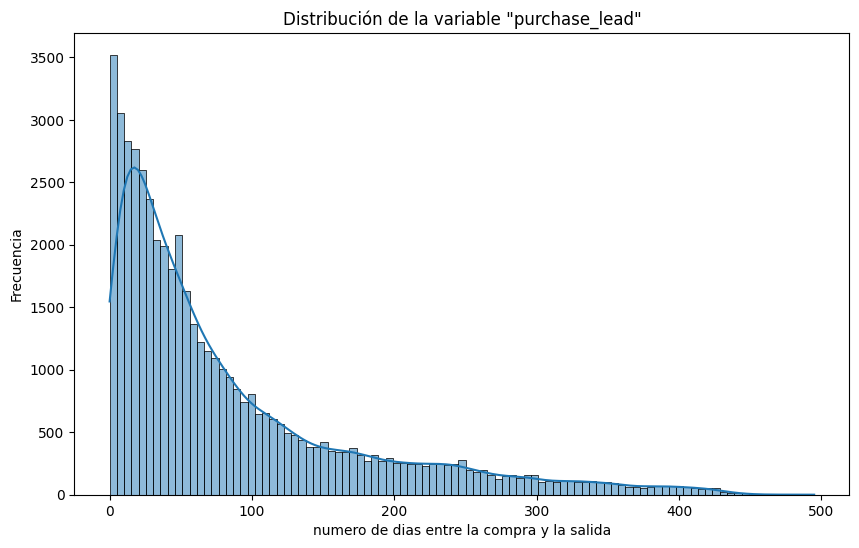

In [249]:
# Graficams la distribución 	purchase_lead
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered.purchase_lead, kde=True)
plt.title('Distribución de la variable "purchase_lead"')

plt.ylabel('Frecuencia')
plt.xlabel('numero de dias entre la compra y la salida')
plt.show()

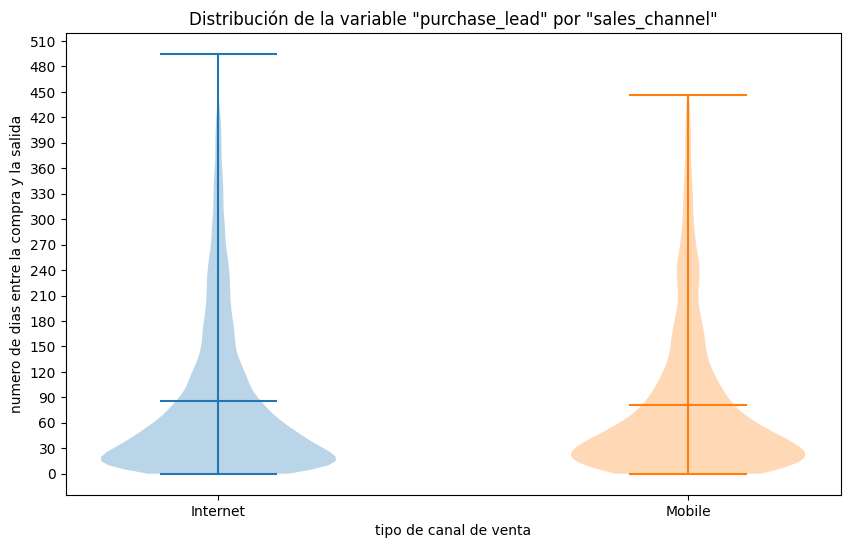

In [250]:
fig, ax = plt.subplots(figsize=(10, 6))

# Obtenemos los valores únicos de 'sales_channel'
channels = df_filtered['sales_channel'].unique()

# Creamos un gráfico de violín para cada valor único de 'sales_channel'
for i, channel in enumerate(channels):
    data = df_filtered[df_filtered['sales_channel'] == channel]
    ax.violinplot(data['purchase_lead'], positions=[i], showmeans=True)

# Configuramos las etiquetas del eje x con los valores únicos de 'sales_channel'
ax.set_xticks(np.arange(len(channels)))
ax.set_xticklabels(channels)

ax.set_xlabel('tipo de canal de venta')
ax.set_ylabel('numero de dias entre la compra y la salida')
ax.set_yticks(range(0, 511, 30))
plt.title('Distribución de la variable "purchase_lead" por "sales_channel"')
plt.show()

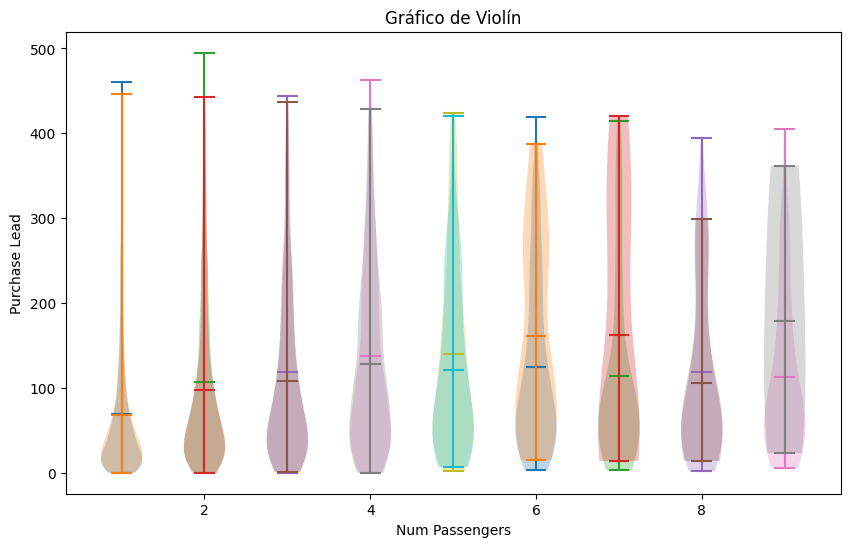

In [251]:
count = df_filtered.groupby(["num_passengers", "sales_channel"])["purchase_lead"]

# Creamos una figura y ejes
fig, ax = plt.subplots(figsize=(10, 6))

# Iteramos sobre los grupos generados por groupby
for key, group in count:
    # Creamos un gráfico de violín para cada grupo
    ax.violinplot(group, positions=[key[0]], showmeans=True)  # Utilizamos solo la primera parte de la clave (num_passengers) como posición

# Establecemos el título y las etiquetas de los ejes
ax.set_title('Gráfico de Violín')
ax.set_xlabel('Num Passengers')
ax.set_ylabel('Purchase Lead')

plt.show()

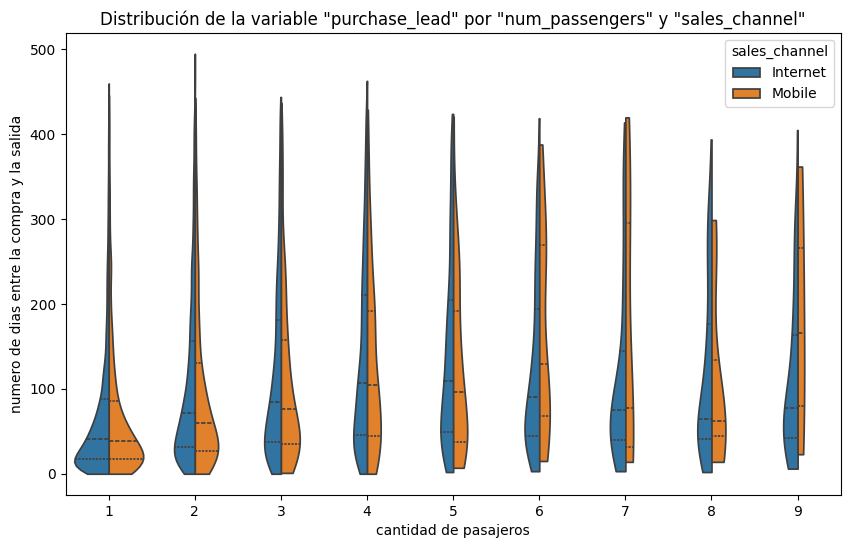

In [252]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(data=df_filtered, x="num_passengers", y="purchase_lead", hue="sales_channel", split=True, inner="quartile",cut=0)

ax.set_title('Distribución de la variable "purchase_lead" por "num_passengers" y "sales_channel"')

# Cambiamos el nombre a los ejes
ax.set_xlabel('cantidad de pasajeros')
ax.set_ylabel('numero de dias entre la compra y la salida')

plt.show()


### Relacion entre num_passengers, Sales_channel y Lenght_of_stay

In [253]:
stay_stats_by_passengers_and_channel = df_filtered.groupby(["num_passengers", "sales_channel"])["length_of_stay"].describe()

stay_stats_by_passengers_and_channel

count       mean        std  min  25%   50%  \
num_passengers sales_channel                                                  
1              Internet       27790.0  26.878050  37.255884  0.0  5.0  19.0   
               Mobile          3556.0  19.636952  28.109502  1.0  5.0   6.0   
2              Internet       11417.0  20.169659  32.023230  0.0  5.0   6.0   
               Mobile          1378.0  14.500000  30.803150  1.0  4.0   6.0   
3              Internet        2554.0  16.538763  21.030434  0.0  5.0   6.0   
               Mobile           385.0  11.618182  13.214858  2.0  5.0   6.0   
4              Internet        1616.0  14.620668  16.005968  1.0  5.0   6.0   
               Mobile           167.0  11.023952  12.689030  3.0  5.0   6.0   
5              Internet         495.0  13.537374  12.837749  1.0  5.0   6.0   
               Mobile            66.0   7.424242   8.188285  4.0  4.0   5.0   
6              Internet         254.0  10.866142  24.825036  2.0  5.0   6.0   
               Mobile            35.0   9.828571  12.123108  2.0  4.5   5.0   
7              Internet         101.0   9.435644   9.941243  1.0  5.0   6.0   
               Mobile            13.0   7.615385   5.156524  4.0  5.0   6.0   
8              Internet          77.0  11.376623  17.839223  2.0  5.0   5.0   
               Mobile            12.0   6.500000   3.343923  5.0  5.0   6.0   
9              Internet          62.0   6.274194   5.044618  3.0  4.0   5.0   
               Mobile             4.0   6.000000   0.000000  6.0  6.0   6.0   

                               75%    max  
num_passengers sales_channel               
1              Internet       31.0  778.0  
               Mobile         26.0  513.0  
2              Internet       24.0  773.0  
               Mobile         17.0  369.0  
3              Internet       23.0  335.0  
               Mobile         17.0  107.0  
4              Internet       21.0  214.0  
               Mobile          6.0   91.0  
5              Internet       20.0   72.0  
               Mobile          6.0   43.0  
6              Internet        6.0  362.0  
               Mobile          6.0   65.0  
7              Internet        6.0   72.0  
               Mobile          6.0   21.0  
8              Internet        6.0   78.0  
               Mobile          6.0   17.0  
9              Internet        6.0   30.0  
               Mobile          6.0    6.0

En promedio las personas que viajan solas tienen una estadia mayor

In [254]:
# Desapilamos el DataFrame y seleccionamos la columna 'count'
counts_by_channel = stay_stats_by_passengers_and_channel.unstack()["count"]
counts_by_channel

sales_channel,Internet,Mobile
num_passengers,,
1,27790.0,3556.0
2,11417.0,1378.0
3,2554.0,385.0
4,1616.0,167.0
5,495.0,66.0
6,254.0,35.0
7,101.0,13.0
8,77.0,12.0
9,62.0,4.0


In [255]:
# Calculamos la proporción de reservas por Internet y Móvil
counts_by_channel["Internet_to_Mobile_ratio"] = counts_by_channel["Internet"] / counts_by_channel["Mobile"]

In [256]:
# Calculamos la media de la proporción
average_ratio = counts_by_channel["Internet_to_Mobile_ratio"].mean()
print(f'La proporción promedio de reservas por Internet a Móvil es de {average_ratio:.2f}')

La proporción promedio de reservas por Internet a Móvil es de 8.54


La proporcionalidad entre las personas que contratan el servicio atraves de internet o Mobile se mantiene constante en el lapso de tiempo entre 2014 a 2023.

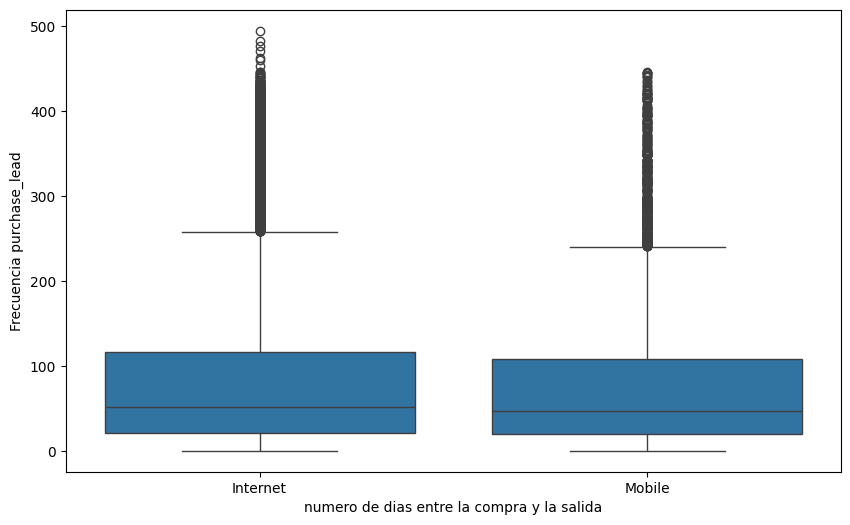

In [257]:
df_filtered.groupby(["sales_channel"])["purchase_lead"]

df_filtered.groupby(["sales_channel"])["purchase_lead"].describe()

# graficams
plt.figure(figsize=(10, 6))
sns.boxplot(x='sales_channel', y='purchase_lead', data=df_filtered)
plt.ylabel('Frecuencia purchase_lead')
plt.xlabel('numero de dias entre la compra y la salida')
plt.show()

Relacion entre Número de días en el destino antes del regreso y Número de días entre el momento de la reserva y el momento del viaje.

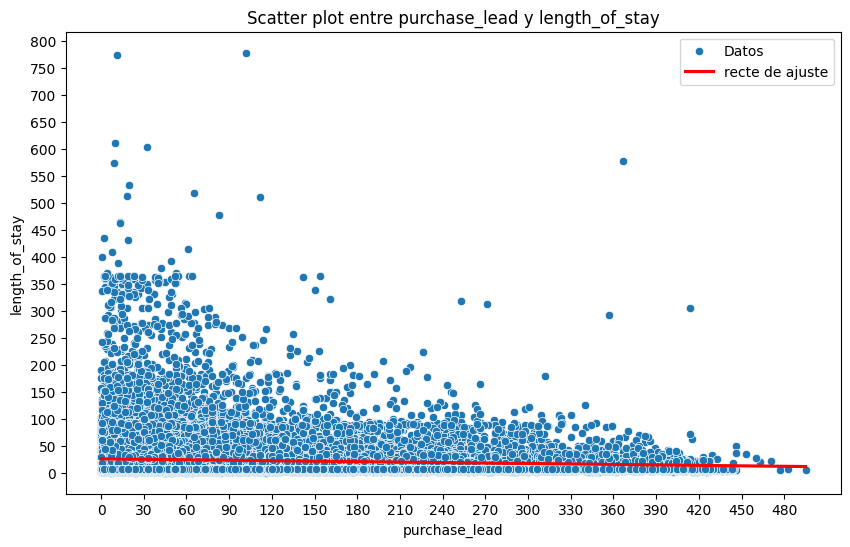

In [258]:
# grafic de scarter plot entre purchase_lead y length_of_stay
plt.figure(figsize=(10, 6))
sns.scatterplot(x='purchase_lead', y='length_of_stay', data=df_filtered)
plt.title('Scatter plot entre purchase_lead y length_of_stay')
plt.ylabel('Número de días en el destino antes del regreso')
plt.xlabel('numero de dias entre la compra y la salida')

# Añadimos una línea de regresión
sns.regplot(x='purchase_lead', y='length_of_stay', data=df_filtered, scatter=False, color='red')
#agregamos leyenda
plt.legend(['Datos', 'recte de ajuste'])

plt.xticks(range(0, 501, 30))
plt.yticks(range(0, 811, 50))


plt.show()


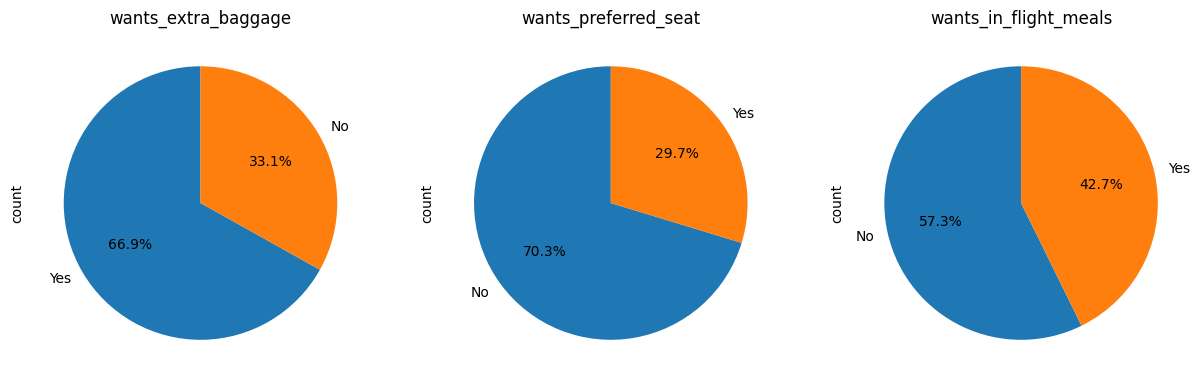

In [259]:
# grafico de  torta wants_extra_baggage, wants_preferred_seat, wants_in_flight_meals subplot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

df_filtered['wants_extra_baggage'].replace({1:"Yes",0:"No"}).value_counts().plot.pie(ax=ax[0], autopct='%1.1f%%', startangle=90)
ax[0].set_title('wants_extra_baggage')

df_filtered['wants_preferred_seat'].replace({1:"Yes",0:"No"}).value_counts().plot.pie(ax=ax[1], autopct='%1.1f%%', startangle=90)
ax[1].set_title('wants_preferred_seat')

df_filtered['wants_in_flight_meals'].replace({1:"Yes",0:"No"}).value_counts().plot.pie(ax=ax[2], autopct='%1.1f%%', startangle=90)
ax[2].set_title('wants_in_flight_meals')


plt.show()


In [260]:
columns = ["wants_extra_baggage", "wants_preferred_seat", "wants_in_flight_meals"]
df = df_filtered[columns].apply(pd.Series.value_counts)
df


,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals
0,16550,35135,28631
1,33432,14847,21351


In [261]:
df_grouped = df_filtered.groupby(["wants_extra_baggage", "wants_preferred_seat", "wants_in_flight_meals"])["length_of_stay"].mean().reset_index(name='mean')
df_grouped

,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,mean
0,0,0,0,14.717335
1,0,0,1,15.999122
2,0,1,0,11.713918
3,0,1,1,12.311562
4,1,0,0,25.133988
5,1,0,1,30.337858
6,1,1,0,21.322229
7,1,1,1,29.948119


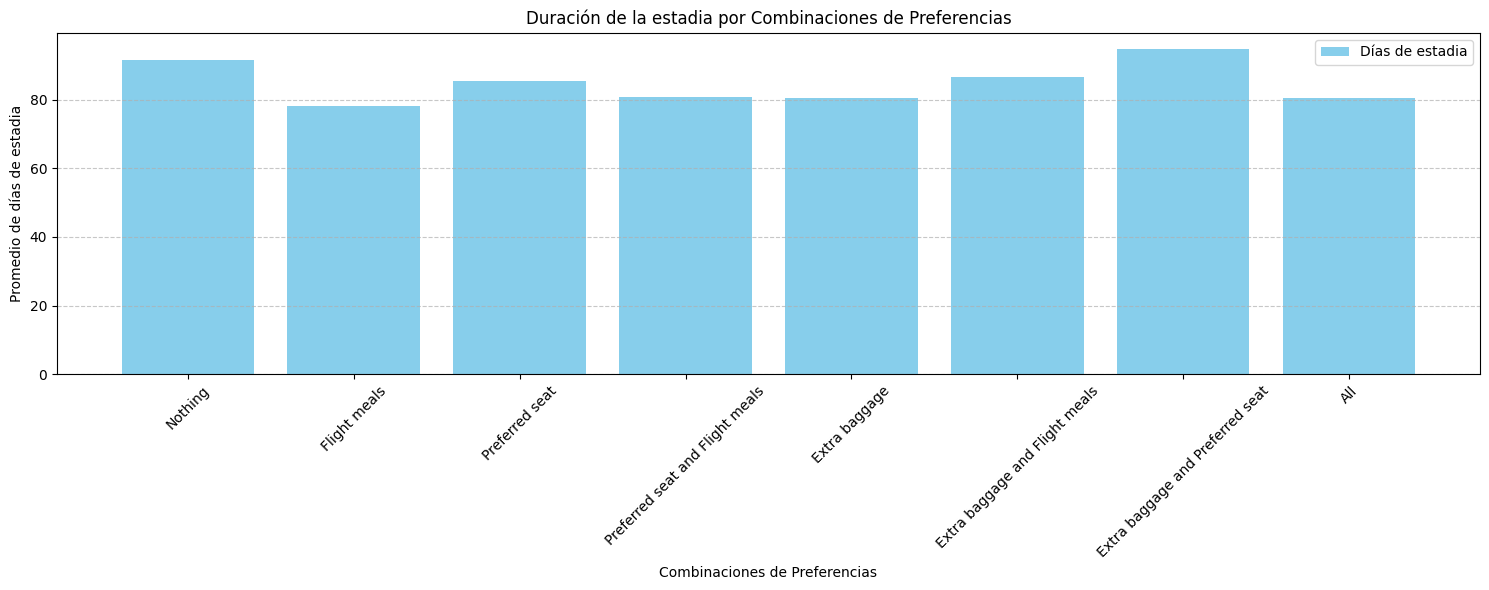

In [262]:
df_grouped = df_filtered.groupby(["wants_extra_baggage", "wants_preferred_seat", "wants_in_flight_meals"])["purchase_lead"]
df_grouped_mean = df_grouped.mean().reset_index()

#Diccionario de las combinaciones
dictionary = {"0-0-0":"Nothing","0-0-1":"Flight meals","0-1-0":"Preferred seat","0-1-1":"Preferred seat and Flight meals","1-0-0":"Extra baggage","1-0-1":"Extra baggage and Flight meals","1-1-0":"Extra baggage and Preferred seat","1-1-1":"All",}

# Graficar
plt.figure(figsize=(15, 6))
plt.bar(df_grouped_mean.index, df_grouped_mean['purchase_lead'], color='skyblue')
plt.xlabel('Combinaciones de Preferencias')
plt.ylabel('Promedio de días de estadia')
plt.title('Duración de la estadia por Combinaciones de Preferencias')
plt.xticks(df_grouped_mean.index, labels=df_grouped_mean[['wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']].astype(str).agg('-'.join, axis=1).replace(to_replace=dictionary), rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.legend(['Días de estadia'])
plt.show()


# Relacion entre los dataset

In [263]:
# Agrupar las reservas por día de la semana
reservas_por_dia = df_filtered.groupby('flight_day')['booking_complete'].count().reset_index()
reservas_por_dia.columns = ['dia_semana', 'num_reservas']

# Agrupar las revisiones por día de la semana
reviews_por_dia = df_cleaned_reviews.groupby('day_of_week')['comments'].count().reset_index()
reviews_por_dia.columns = ['dia_semana', 'num_reviews']

# Combinar los DataFrames
datos_combinados = pd.merge(reviews_por_dia, reservas_por_dia, on='dia_semana', how='outer')

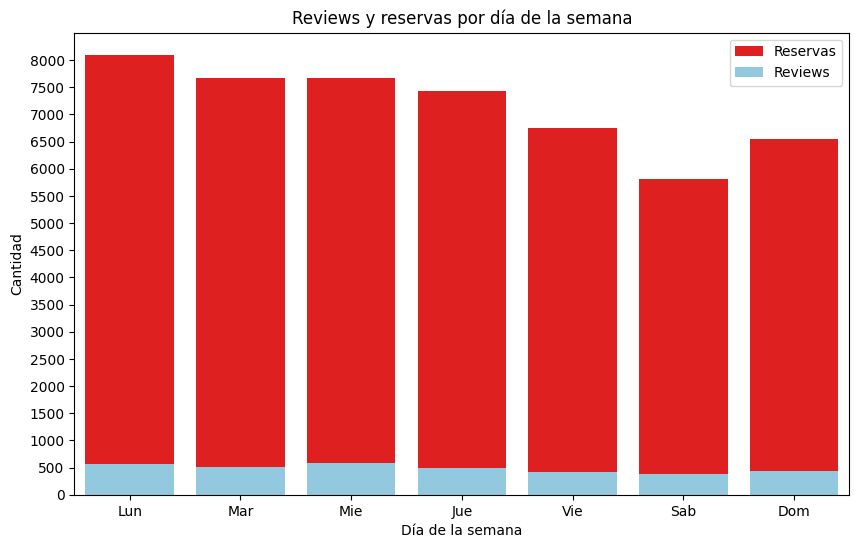

In [264]:
# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(x='dia_semana', y='num_reservas', data=datos_combinados, color='red', label='Reservas')
sns.barplot(x='dia_semana', y='num_reviews', data=datos_combinados, color='skyblue', label='Reviews')
plt.legend()
plt.title('Reviews y reservas por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Cantidad')

plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Lun', 'Mar', 'Mie', 'Jue', 'Vie', 'Sab', 'Dom'])

# ajustamos el rango del ejes y separacion set_yticks
plt.yticks(np.arange(0, 8001, 500))

plt.show()


In [265]:
stat_eviews = df_cleaned_reviews.groupby('day_of_week')[["rates", "verified"]].mean()

stat_booking = df_filtered.groupby('flight_day')[["num_passengers", "purchase_lead", "length_of_stay", "flight_hour", "wants_extra_baggage", "wants_preferred_seat", "wants_in_flight_meals", "flight_duration", "booking_complete"]].mean()

stat = pd.concat([stat_eviews, stat_booking], axis=1)
corr = stat.corr()

'stat_eviews = df_cleaned_reviews.groupby(\'day_of_week\')[["rates", "verified"]].mean()\n\nstat_booking = df_filtered.groupby(\'flight_day\')[["num_passengers", "purchase_lead", "length_of_stay", "flight_hour", "wants_extra_baggage", "wants_preferred_seat", "wants_in_flight_meals", "flight_duration", "booking_complete"]].mean()\n\nstat = pd.concat([stat_eviews, stat_booking], axis=1)\ncorr = stat.corr()'

In [266]:
stat_eviews = df_cleaned_reviews.groupby('day_of_week')[["rates", "verified"]].mean().reset_index().rename(columns = {"day_of_week":"flight_day"})

stat_booking = df_filtered.groupby('flight_day')[["num_passengers", "purchase_lead", "length_of_stay", "flight_hour", "wants_extra_baggage", "wants_preferred_seat", "wants_in_flight_meals", "flight_duration", "booking_complete"]].mean().reset_index()

stat = pd.merge(stat_eviews,stat_booking,how="inner")
corr = stat.corr()

In [267]:
stat

,flight_day,rates,verified,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,1,4.783972,0.294425,1.596049,94.096543,22.573086,8.998765,0.663210,0.304198,0.422469,7.264507,0.148519
1,2,4.938976,0.271654,1.570795,81.565189,23.350196,9.011864,0.674055,0.284355,0.417601,7.257383,0.147197
2,3,4.900338,0.243243,1.579194,74.190066,23.006779,9.014079,0.672663,0.301265,0.424716,7.261251,0.163212
3,4,4.744330,0.282474,1.575913,76.264314,23.472316,8.994881,0.671966,0.286811,0.431766,7.249212,0.151152
4,5,4.547619,0.290476,1.557183,73.795236,23.323717,8.768901,0.667998,0.292055,0.433496,7.250237,0.145436
5,6,4.476684,0.360104,1.615080,85.447237,23.130487,8.981580,0.673610,0.307454,0.432605,7.301823,0.148218
6,7,5.260674,0.285393,1.653893,109.626412,22.481679,9.730382,0.658626,0.305649,0.430534,7.373501,0.141374


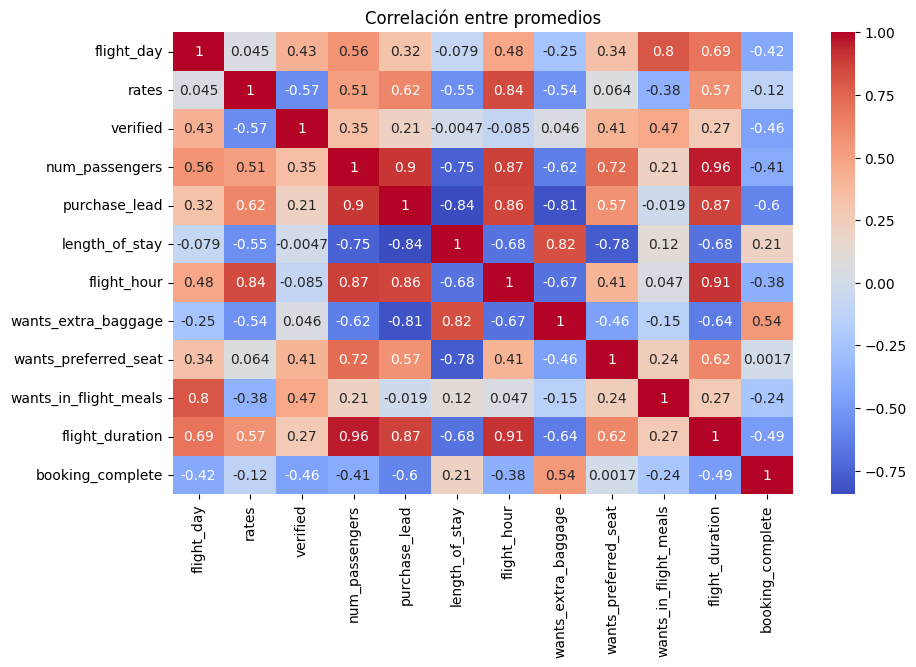

In [268]:
# Mapa de calor
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlación entre promedios')
plt.show()

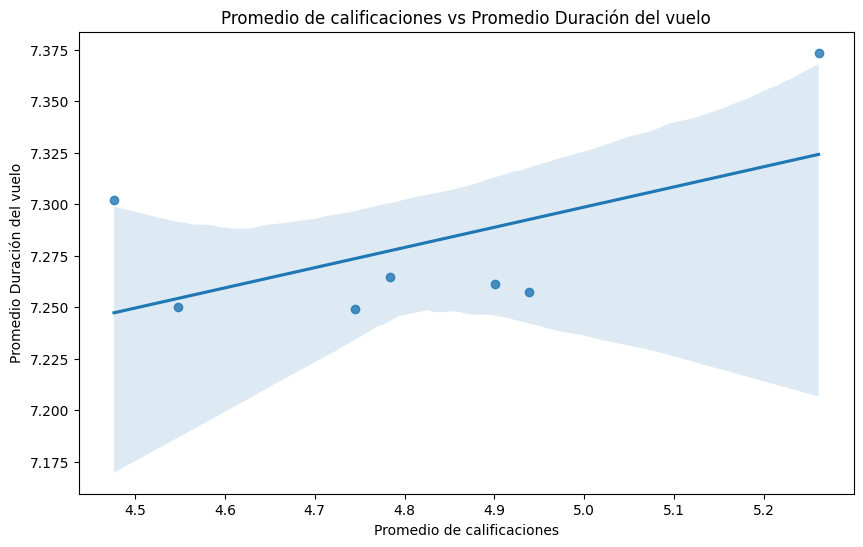

In [407]:
# scatter plot entre las variables "rates" y "flight_duration"
plt.figure(figsize=(10, 6))
# linea de tendencia
sns.regplot(x='rates', y='flight_duration', data=stat)
plt.title('Promedio de calificaciones vs Promedio Duración del vuelo')
plt.xlabel('Promedio de calificaciones')
plt.ylabel('Promedio Duración del vuelo')
plt.show()

Amedida que aumenta el promedio de la duracion del vuelo, aumenta el promedio de la calificacion

<ipython-input-270-c3a72faa7287>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Lun', 'Mar', 'Mie', 'Jue', 'Vie', 'Sab', 'Dom'])


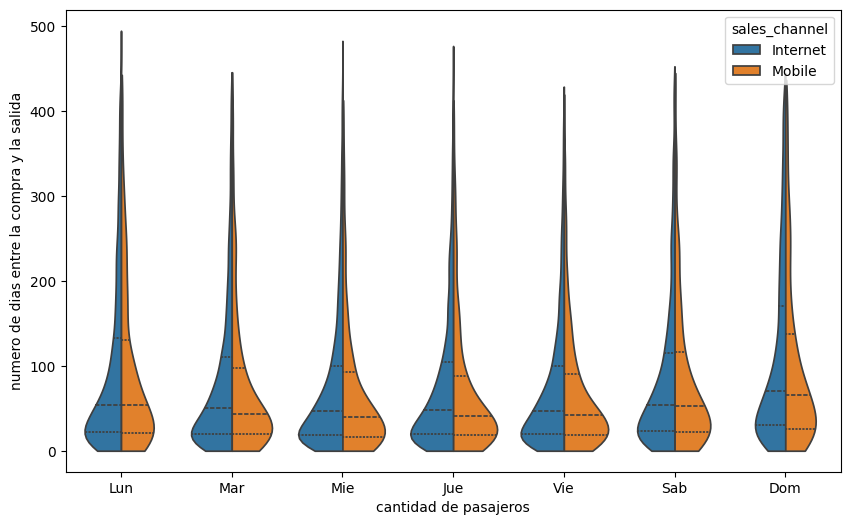

In [270]:
#Violin plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(data=df_filtered, x="flight_day", y="purchase_lead", hue="sales_channel", split=True, inner="quartile",cut=0)

ax.set_xticklabels(['Lun', 'Mar', 'Mie', 'Jue', 'Vie', 'Sab', 'Dom'])

ax.set_xlabel('cantidad de pasajeros')
ax.set_ylabel('numero de dias entre la compra y la salida')

plt.show()

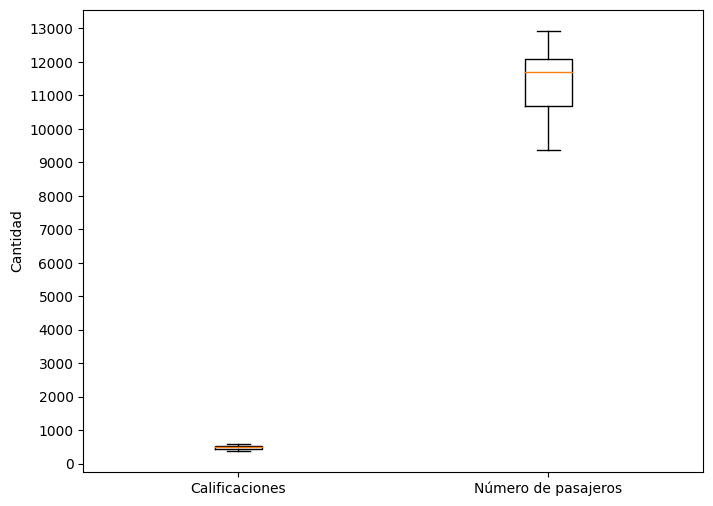

In [271]:
reviews_by_day = df_cleaned_reviews.groupby('day_of_week')['rates'].count().reset_index()

# Agrupar las reservas por día de la semana y contar el número de pasajeros
bookings_by_day = df_filtered.groupby('flight_day')['num_passengers'].sum().reset_index()
bookings_by_day.columns = ['day_of_week', 'num_passengers']

# Unir los datos de revisiones y reservas por día de la semana
data = pd.merge(reviews_by_day, bookings_by_day, how='outer', on='day_of_week')
data = data.sort_values('day_of_week')

# Crear el gráfico de caja
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot([data['rates'], data['num_passengers']], labels=['Calificaciones', 'Número de pasajeros'])
ax.set_yticks(np.arange(0, 13001, 1000))
plt.xticks(rotation=0)
plt.ylabel('Cantidad')
plt.show()

In [272]:
day_of_week_map = {
    1: 'Lunes',
    2: 'Martes',
    3: 'Miércoles',
    4: 'Jueves',
    5: 'Viernes',
    6: 'Sábado',
    7: 'Domingo'
}

df_cleaned_reviews['day_name'] = df_cleaned_reviews['day_of_week'].map(day_of_week_map)

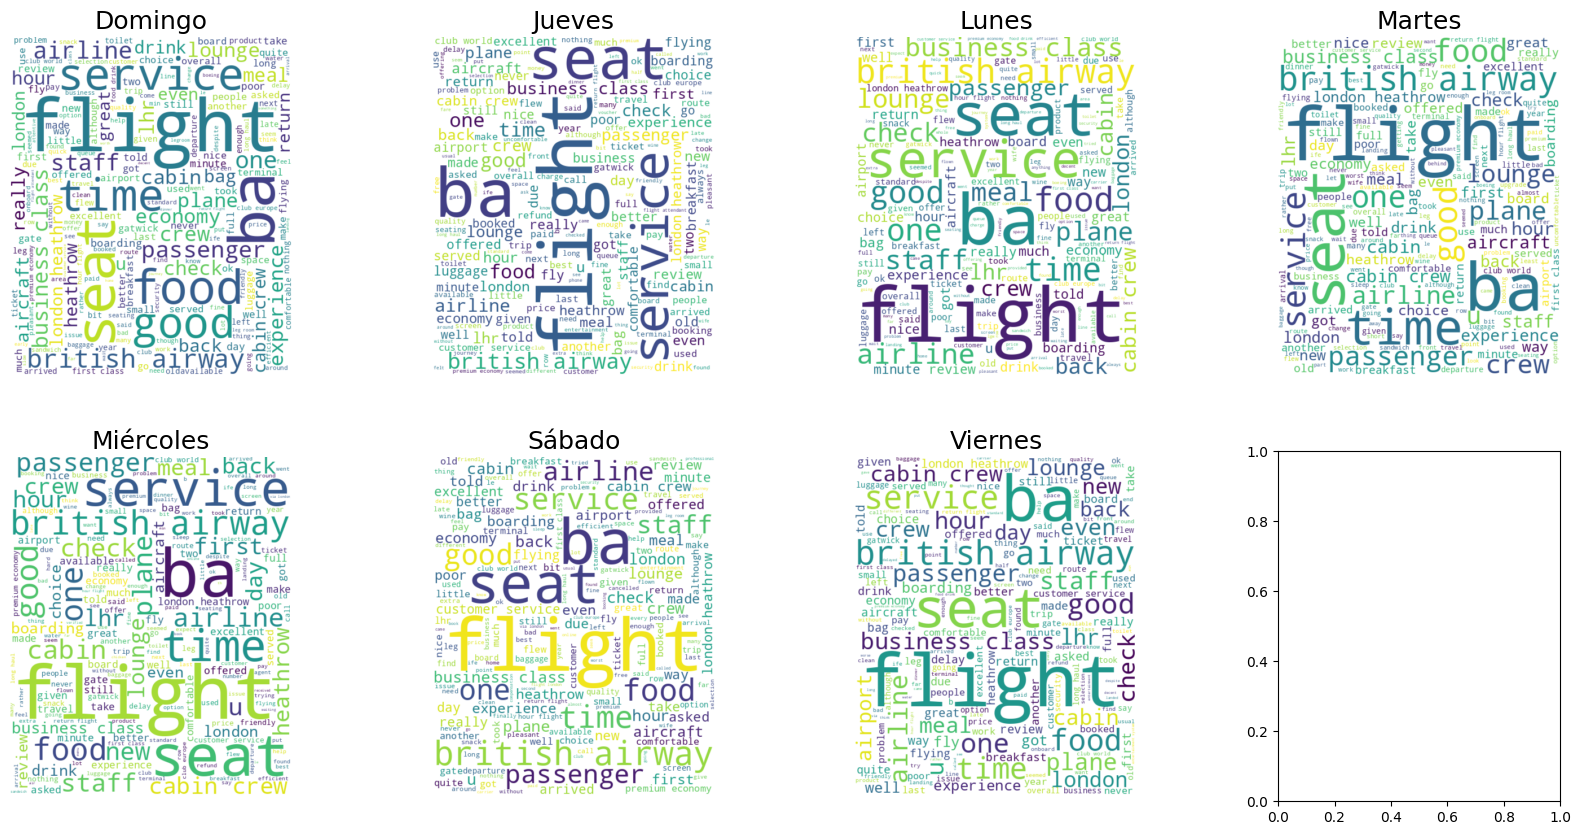

In [273]:
grouped_comments = df_cleaned_reviews.groupby('day_name')['comments'].apply(lambda x: ' '.join(x))

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axes = axes.flatten()

for i, (day, comments) in enumerate(grouped_comments.items()):
    wordcloud = WordCloud(width=500, height=600, background_color="white").generate(comments)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(day, fontsize=18)
    axes[i].axis("off")

plt.subplots_adjust(wspace=0.5)

plt.show()

Relacion entre dataframes por Country

In [274]:
df_country_rates_mean = df_cleaned_reviews.groupby(["country"])["rates"].mean().reset_index()
df_country_flight_mean = df_filtered.groupby(["booking_origin"])["flight_duration"].mean().reset_index().rename(columns = {"booking_origin":"country"})
df_country_merge = pd.merge(df_country_rates_mean,df_country_flight_mean,how="inner")

<Figure size 1000x600 with 0 Axes>

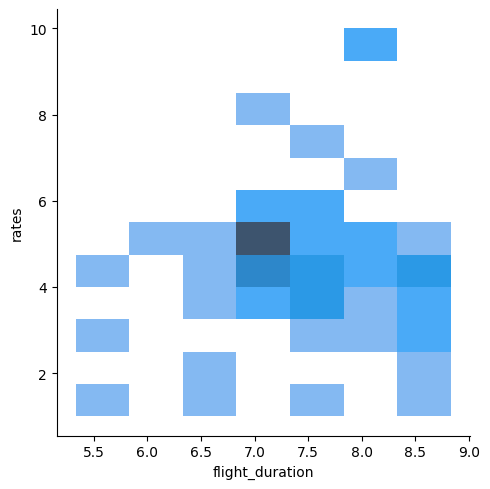

In [275]:
#Displot
plt.figure(figsize=(10, 6))
sns.displot(x='flight_duration', y='rates', data=df_country_merge,)

In [423]:
df_filtered_2 = df_filtered
df_filtered_2["extra_benefit"] = df_filtered_2["wants_extra_baggage"] + df_filtered_2["wants_preferred_seat"] + df_filtered_2["wants_in_flight_meals"]
df_filtered_2 = df_filtered_2.groupby(["booking_origin"])[["extra_benefit",]].mean().reset_index().rename(columns = {"booking_origin":"country"})
df_filtered_2

,country,extra_benefit
0,(not set),1.190476
1,Afghanistan,0.000000
2,Algeria,1.000000
3,Argentina,0.333333
4,Australia,1.552869
...,...,...
99,United Arab Emirates,1.595238
100,United Kingdom,1.410405
101,United States,1.158242
102,Vanuatu,2.000000


In [424]:
df_cleaned_2 = df_cleaned_reviews
df_cleaned_2 = df_cleaned_2.groupby(["country"])["rates"].mean().reset_index().dropna()
df_cleaned_2

,country,rates
0,Argentina,7.666667
1,Australia,5.414966
2,Austria,4.900000
3,Bahrain,1.000000
4,Barbados,9.000000
...,...,...
64,Ukraine,8.000000
65,United Arab Emirates,3.750000
66,United Kingdom,4.897874
67,United States,4.351801


In [425]:
pd_merge_count = pd.merge(df_filtered_2,df_cleaned_2,how="inner").dropna()
pd_merge_count

,country,extra_benefit,rates
0,Argentina,0.333333,7.666667
1,Australia,1.552869,5.414966
2,Austria,1.125000,4.900000
3,Bahrain,1.400000,1.000000
4,Belgium,1.142857,5.809524
5,Brazil,0.888889,4.500000
6,Bulgaria,1.000000,3.666667
7,Canada,1.122807,4.913462
8,China,1.001476,4.888889
9,Cyprus,1.500000,5.000000


In [426]:
#Funcion para obtener el string de continente dado un country name

import pycountry_convert as pc

def country_to_continent(country_name):
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    continent_dict = {"Asia":"Asia","Oceania":"Asia","Europe":"Europe","Africa":"Africa","South America":"America","North America":"America"}
    return continent_dict.get(country_continent_name)

In [427]:
pd_merge_count["continent"] = pd_merge_count['country'].apply(country_to_continent)
pd_merge_count

,country,extra_benefit,rates,continent
0,Argentina,0.333333,7.666667,America
1,Australia,1.552869,5.414966,Asia
2,Austria,1.125000,4.900000,Europe
3,Bahrain,1.400000,1.000000,Asia
4,Belgium,1.142857,5.809524,Europe
5,Brazil,0.888889,4.500000,America
6,Bulgaria,1.000000,3.666667,Europe
7,Canada,1.122807,4.913462,America
8,China,1.001476,4.888889,Asia
9,Cyprus,1.500000,5.000000,Asia


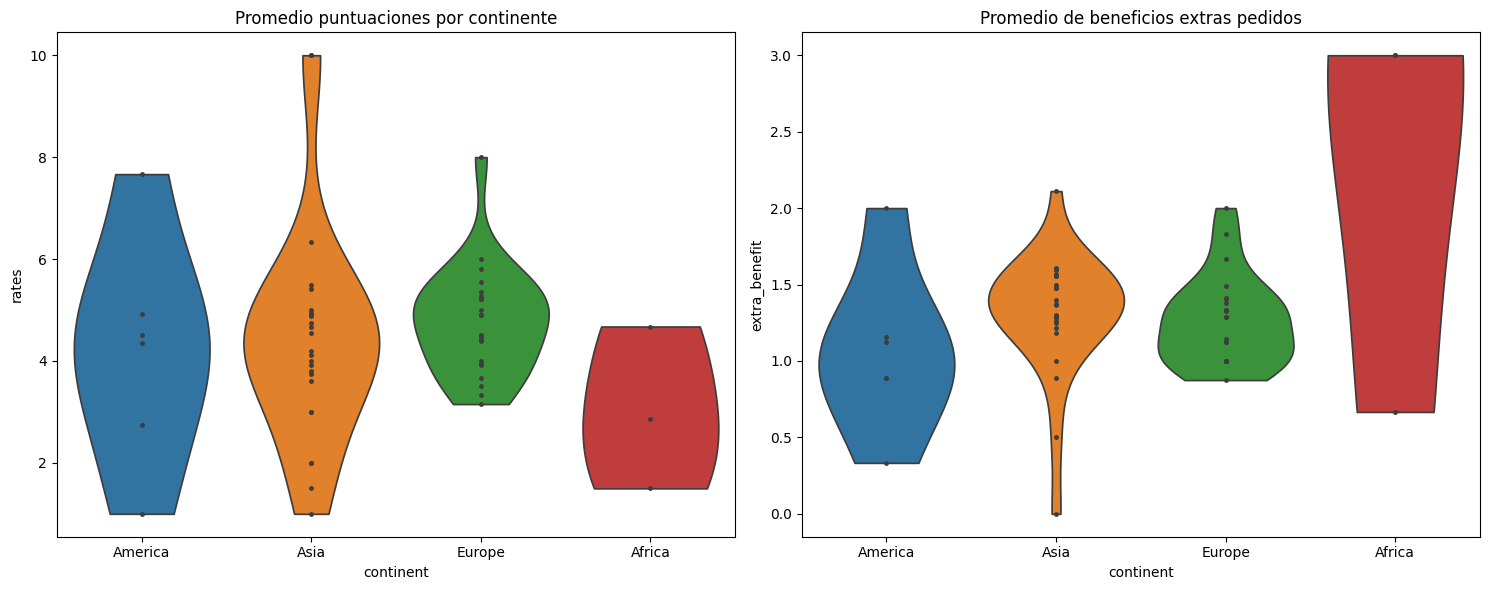

In [428]:
#Violin plot

fig, ax = plt.subplots(1, 2,figsize=(15, 6))

sns.violinplot(ax=ax[0],data=pd_merge_count, x="continent", y="rates",hue="continent", inner="point",cut=0)
ax[0].set_title('Promedio puntuaciones por continente')

sns.violinplot(ax=ax[1],data=pd_merge_count, x="continent", y="extra_benefit",hue="continent", inner="point",cut=0)
ax[1].set_title('Promedio de beneficios extras pedidos')

plt.tight_layout()
plt.show()

In [ ]:
df_cleaned3 = df_cleaned_reviews
df_cleaned3 = df_cleaned3.groupby(["day_of_week","country"])["rates"].mean().reset_index().dropna()

df_filtered3 = df_filtered.groupby(["flight_day","booking_origin"])["num_passengers"].mean().reset_index().rename(columns = {"booking_origin":"country","flight_day":"day_of_week"}).dropna()
df_cleaned3


In [ ]:
df_filtered3

In [ ]:
pd_merge_count2 = pd.merge(df_cleaned3,df_filtered3,how="inner").dropna()
pd_merge_count2

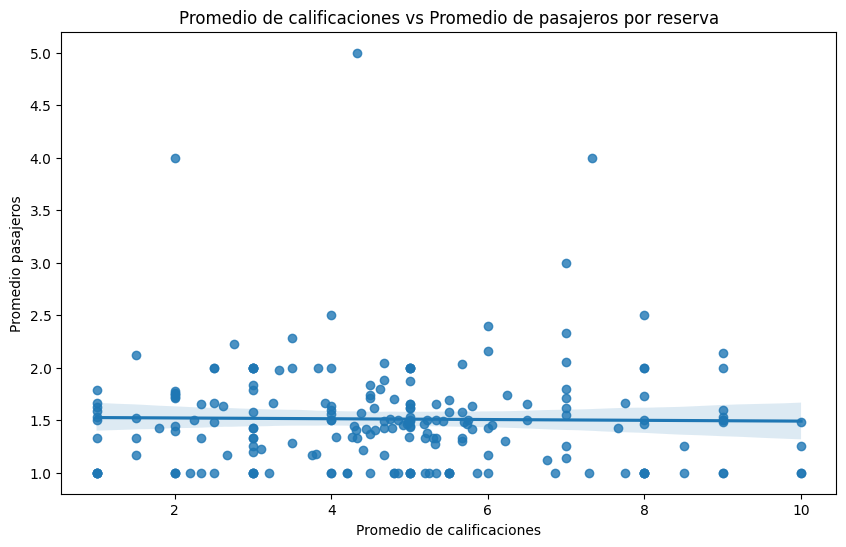

In [484]:
# scatter plot entre las variables "rates" y "flight_duration"
plt.figure(figsize=(10, 6))
# linea de tendencia
sns.regplot(x='rates', y='num_passengers', data=pd_merge_count2)
plt.title('Promedio de calificaciones vs Promedio de pasajeros por reserva')
plt.xlabel('Promedio de calificaciones')
plt.ylabel('Promedio pasajeros')
plt.show()

In [483]:
df_filtered4 = df_filtered
df_filtered4["extra_benefit"] = df_filtered4["wants_extra_baggage"] + df_filtered4["wants_preferred_seat"] + df_filtered4["wants_in_flight_meals"]
df_filtered4 = df_filtered4.groupby(["flight_day"])["extra_benefit"].mean().reset_index().rename(columns = {"flight_day":"day_of_week"}).dropna()

df_filtered4

,day_of_week,extra_benefit
0,1,1.389877
1,2,1.376010
2,3,1.398644
3,4,1.390543
4,5,1.393549
5,6,1.413668
6,7,1.394809


In [455]:
df_cleaned4 = df_cleaned_reviews
df_cleaned4 = df_cleaned4.groupby(["day_of_week"])["rates"].mean().reset_index().dropna()
df_cleaned4

,day_of_week,rates
0,1,4.783972
1,2,4.938976
2,3,4.900338
3,4,4.744330
4,5,4.547619
5,6,4.476684
6,7,5.260674


In [468]:
def daynumber_to_week_instance(day_number):
    if day_number <= 5:
      return "regular day"
    else:
        return "weekend"

In [465]:
pd_merge_count4 = pd.merge(df_cleaned4,df_filtered4,how="inner").dropna()
pd_merge_count4

,day_of_week,rates,extra_benefit
0,1,4.783972,1.389877
1,2,4.938976,1.376010
2,3,4.900338,1.398644
3,4,4.744330,1.390543
4,5,4.547619,1.393549
5,6,4.476684,1.413668
6,7,5.260674,1.394809


In [466]:
pd_merge_count4["week_instance"] = pd_merge_count4["day_of_week"].apply(daynumber_to_week_instance)
pd_merge_count4

,day_of_week,rates,extra_benefit,week_instance
0,1,4.783972,1.389877,regular day
1,2,4.938976,1.376010,regular day
2,3,4.900338,1.398644,regular day
3,4,4.744330,1.390543,regular day
4,5,4.547619,1.393549,weekend
5,6,4.476684,1.413668,weekend
6,7,5.260674,1.394809,weekend


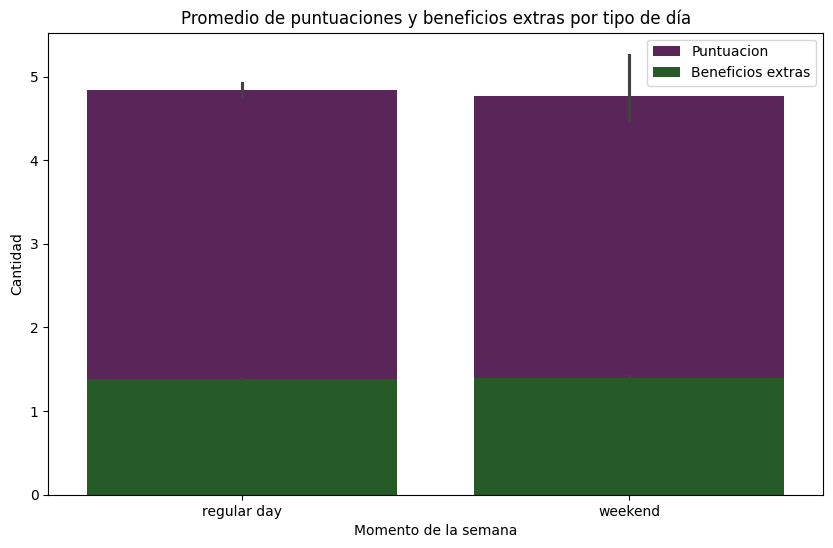

In [500]:
# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(x='week_instance', y='rates', data=pd_merge_count4, color='purple', label='Puntuacion',saturation = 0.4)
sns.barplot(x='week_instance', y='extra_benefit', data=pd_merge_count4, color='green', label='Beneficios extras',saturation = 0.4)

plt.legend()
plt.title('Promedio de puntuaciones y beneficios extras por tipo de día')
plt.xlabel('Momento de la semana')
plt.ylabel('Cantidad')

plt.show()

In [485]:
df_filtered5 = df_filtered
df_filtered5 = df_filtered5.groupby(["flight_day"])["flight_duration"].mean().reset_index().rename(columns = {"flight_day":"day_of_week"}).dropna()

df_filtered5

,day_of_week,flight_duration
0,1,7.264507
1,2,7.257383
2,3,7.261251
3,4,7.249212
4,5,7.250237
5,6,7.301823
6,7,7.373501


In [486]:
def word_count(string):
    words = string.split()
    count_words = len(words)
    return count_words

In [495]:
df_cleaned5 = df_cleaned_reviews
df_cleaned5["reviews_words_count"] = df_cleaned5["comments"].apply(word_count)

In [496]:
df_cleaned5 = df_cleaned5.groupby(["day_of_week"])["reviews_words_count"].mean().reset_index().dropna()
df_cleaned5

,day_of_week,reviews_words_count
0,1,84.327526
1,2,83.255906
2,3,81.554054
3,4,86.004124
4,5,85.235714
5,6,83.334197
6,7,79.047191


In [497]:
pd_merge_count5 = pd.merge(df_cleaned5,df_filtered5,how="inner").dropna()
pd_merge_count5

,day_of_week,reviews_words_count,flight_duration
0,1,84.327526,7.264507
1,2,83.255906,7.257383
2,3,81.554054,7.261251
3,4,86.004124,7.249212
4,5,85.235714,7.250237
5,6,83.334197,7.301823
6,7,79.047191,7.373501


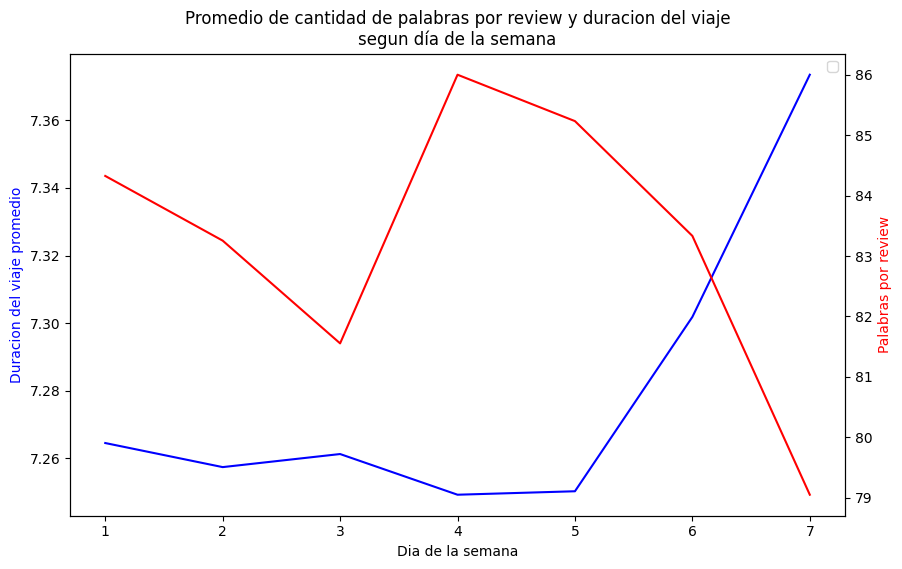

In [513]:
plt.figure(figsize=(10, 6))

ax1 = sns.lineplot(data=pd_merge_count5, x="day_of_week", y="flight_duration",color='blue')

ax2 = ax1.twinx()

sns.lineplot(data=pd_merge_count5, x="day_of_week", y="reviews_words_count",ax=ax2,color='red')

ax1.set_xlabel('Dia de la semana')
ax1.set_ylabel('Duracion del viaje promedio', color='blue')
ax2.set_ylabel('Palabras por review promedio', color='red')


plt.legend()
plt.title('Promedio de cantidad de palabras por review y duracion del viaje\nsegun día de la semana')
plt.xlabel('Momento de la semana')
plt.ylabel('Palabras por review')

plt.show()